In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## Project Overview
The goal of these models is to identify **cost of living factors** that are associated with a **decline in population**, as captured by the binary target variable `pct_diff_binary`. A better understanding of these relationships can guide policy-makers in addressing the drivers behind population loss.

## Data Preprocessing and Cleaning
- **Handling missing values:**  
  Rows with missing data are dropped to ensure a clean dataset for analysis. Future work could include imputation strategies to preserve more data.
- **Currency conversion:**  
  Cost of living features such as housing and healthcare expenses were in currency format. Cleaning these values ensures they can be used in numerical operations for machine learning models.

In [2]:
# %% Load and clean the dataset
ml_df = pd.read_csv('Resources/Percent_Change_Data/binary_county_pct_diff.csv')

In [3]:
# Drop rows with NaN values
ml_df.dropna(inplace=True)

In [4]:
# Clean currency columns and convert to float
columns_to_clean = ['housing_yearly', 'food_yearly', 'transportation_yearly', 
                    'healthcare_yearly', 'misc_yearly', 'childcare_yearly', 
                    'taxes_yearly', 'median_family_income']

for col in columns_to_clean:
    ml_df[col] = ml_df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

## Creating New Columns for Total Yearly Costs

In this section, four new columns are created to reflect the combined yearly cost of specific categories (housing, food and taxes) with yearly taxes. The assumption is that taxes (`misc_yearly`) influence these primary living expenses, so the new columns incorporate the sum of each expense category with the yearly misc amount. This helps capture a more holistic view of the total yearly cost for each category.

In [5]:
# Add the yearly misc to the housing cost to create the total yearly housing cost
ml_df['housing_total_yearly'] = ml_df['housing_yearly'] + (ml_df['misc_yearly'] /4)

In [6]:
# Add the yearly misc to the food cost to create the total yearly food cost
ml_df['food_total_yearly'] = ml_df['food_yearly'] + (ml_df['misc_yearly'] / 4)

In [7]:
# Add the yearly misc to the food cost to create the total yearly food cost
ml_df['transportation_total_yearly'] = ml_df['transportation_yearly'] + (ml_df['misc_yearly'] / 4)

In [8]:
# Add the yearly misc to the childcare cost to create the total yearly food cost
ml_df['childcare_total_yearly'] = ml_df['childcare_yearly'] + (ml_df['misc_yearly'] / 4)

In [9]:
ml_df.head()

,Unnamed: 0,state_abv,county,housing_yearly,food_yearly,transportation_yearly,healthcare_yearly,misc_yearly,childcare_yearly,taxes_yearly,median_family_income,pct_diff,pct_diff_binary,housing_total_yearly,food_total_yearly,transportation_total_yearly,childcare_total_yearly
0,0,AK,Aleutians East Borough,15295.2,13826.4,18463.2,20150.4,10312.8,13478.4,13345.2,79922.0,0.90,0,17873.4,16404.6,21041.4,16056.6
1,1,AK,Aleutians West Census Area,22203.6,13826.4,11754.0,20150.4,12756.0,15972.0,14937.6,111607.0,1.38,0,25392.6,17015.4,14943.0,19161.0
2,2,AK,Anchorage Municipality,18061.2,13278.0,17071.2,17029.2,11096.4,18535.2,14593.2,115272.0,-0.32,1,20835.3,16052.1,19845.3,21309.3
3,3,AK,Bethel Census Area,22770.0,14637.6,11872.8,19977.6,13244.4,16077.6,15504.0,67266.0,-0.19,1,26081.1,17948.7,15183.9,19388.7
4,4,AK,Bristol Bay Borough,14671.2,13826.4,21236.4,20150.4,10092.0,13077.6,13857.6,104688.0,-2.99,1,17194.2,16349.4,23759.4,15600.6


## Target Variable: Population Decline Classification
- **Binary Target Definition:**  
  - `0`: No population decline (or increase).
  - `1`: Population decline.
  This binary target allows us to identify which cost of living factors are most associated with population decline. Future versions could explore multi-class classification to account for different magnitudes of population change.


In [10]:
# Find mean for 'pct_diff' column
mean_pct_diff = ml_df['pct_diff'].mean()

print(f"Mean of 'pct_diff' column: {mean_pct_diff}")

Mean of 'pct_diff' column: 0.2884637496007665


In [11]:
# Convert 'pct_diff' to binary target
ml_df['pct_diff_binary'] = ml_df['pct_diff'].apply(lambda x: 0 if x > mean_pct_diff else 1)

In [12]:
# Inverse Transformation of 'median_family_income'
ml_df['income_inverse'] = 1 / ml_df['median_family_income']

In [13]:
# %% Define features and target variable
features = ml_df[['housing_total_yearly', 'food_total_yearly', 'transportation_total_yearly', 
                  'healthcare_yearly', 'childcare_total_yearly', 'taxes_yearly']]
target = ml_df['pct_diff_binary']

## Train-Test Split
We split the dataset into **80% training** and **20% testing** data to ensure that the model can generalize well to unseen data.

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Model Training: Random Forest Classifier
- **Why Random Forest?**  
  Random Forest is robust and provides feature importance insights, helping us identify which cost of living factors are most correlated with population decline.

In [15]:
# Train the Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Make predictions and evaluate the model
y_pred = model.predict(X_test)

In [17]:
# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       295
           1       0.72      0.74      0.73       332

    accuracy                           0.71       627
   macro avg       0.71      0.70      0.70       627
weighted avg       0.71      0.71      0.71       627

Accuracy: 0.7065390749601276


## Feature Importance Analysis
The **feature importance plot** highlights which cost of living factors are most associated with population decline. This helps us identify areas where policy interventions might mitigate population loss.

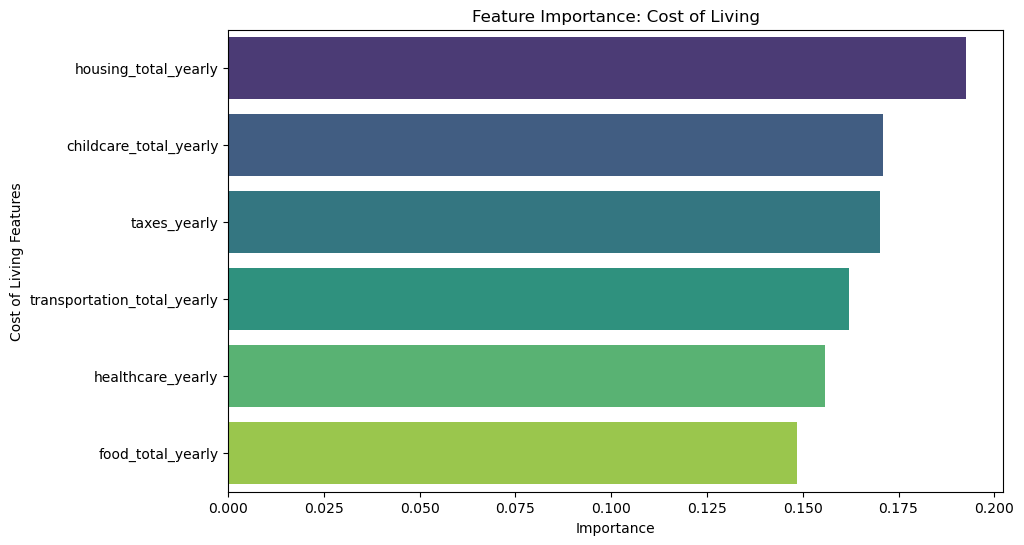

In [18]:
# Feature importance visualization
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances}).sort_values(
    by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance: Cost of Living')
plt.xlabel('Importance')
plt.ylabel('Cost of Living Features')
plt.show()

## Actual vs Predicted Visualization
This scatter plot compares actual vs. predicted values to help us understand where the model performs well and where it struggles. Points close to the diagonal line represent accurate predictions.

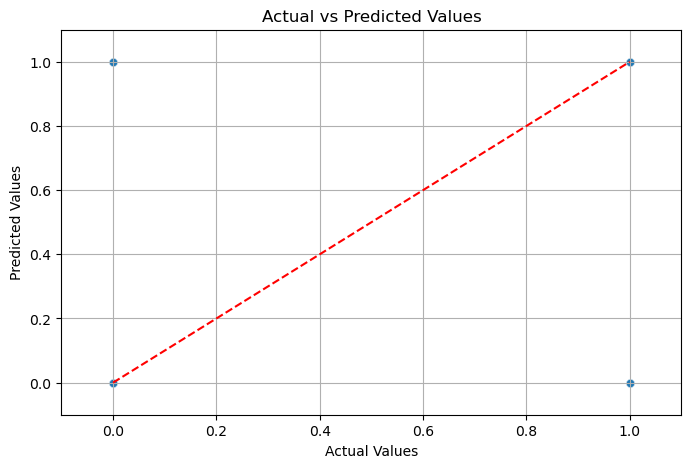

In [19]:
# Actual vs Predicted Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.show()

## Hyperparameter Tuning with GridSearchCV
- **Goal:** Improve model performance by finding the optimal hyperparameters.
- **Key Parameters:**  
  - `n_estimators`: Number of trees in the forest.
  - `max_depth`: Controls the maximum depth of the trees to prevent overfitting.
  - `min_samples_split` and `min_samples_leaf`: Control the minimum samples for splitting and leaf nodes to reduce overfitting.


In [20]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [22]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [23]:
# Get best model and evaluate
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [24]:

# Make predictions with the best model
y_pred_best = best_model.predict(X_test)

In [25]:
# Evaluate the optimized model
print("\nOptimized Model Performance:")
print(classification_report(y_test, y_pred_best))
print("Optimized Accuracy:", accuracy_score(y_test, y_pred_best))


Optimized Model Performance:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       295
           1       0.70      0.75      0.72       332

    accuracy                           0.69       627
   macro avg       0.69      0.69      0.69       627
weighted avg       0.69      0.69      0.69       627

Optimized Accuracy: 0.69377990430622


## Model Comparison: Logistic Regression and XGBoost
**Why Compare Models?**  
Comparing multiple models helps ensure robustness and identifies the most effective model for predicting population decline.
- **Logistic Regression:** Provides a baseline by assuming linear relationships between features.
- **XGBoost:** A powerful model that captures feature interactions and often performs well on structured data.


In [26]:
# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression Accuracy: 0.6523125996810207


In [27]:
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.6858054226475279


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


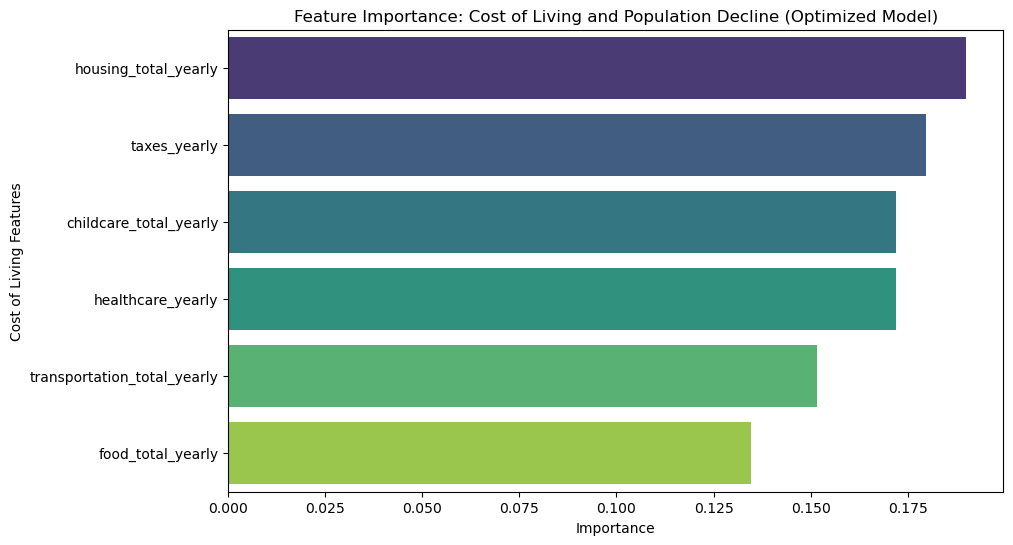

In [28]:
importances_optimized = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances_optimized}).sort_values(
    by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance: Cost of Living and Population Decline (Optimized Model)')
plt.xlabel('Importance')
plt.ylabel('Cost of Living Features')
plt.show()

## Conclusion
- The **Random Forest model** with optimized hyperparameters performed the best, indicating that it can effectively identify the cost of living factors associated with population decline.
- **XGBoost** also performed well, suggesting that ensemble models are well-suited for this problem.
- **Policy Implications:** The feature importance analysis can guide efforts to address key cost-of-living factors (such as housing or healthcare) that may drive population loss.
- **Future Improvements:**
  - **Model ensembling:** Combine models to boost predictive power.
  - **Feature engineering:** Add interaction terms to capture non-linear relationships.
  - **Explainability:** Use SHAP values for deeper insights into individual predictions.
  - **Multi-class classification:** Explore more granular classifications of population change.

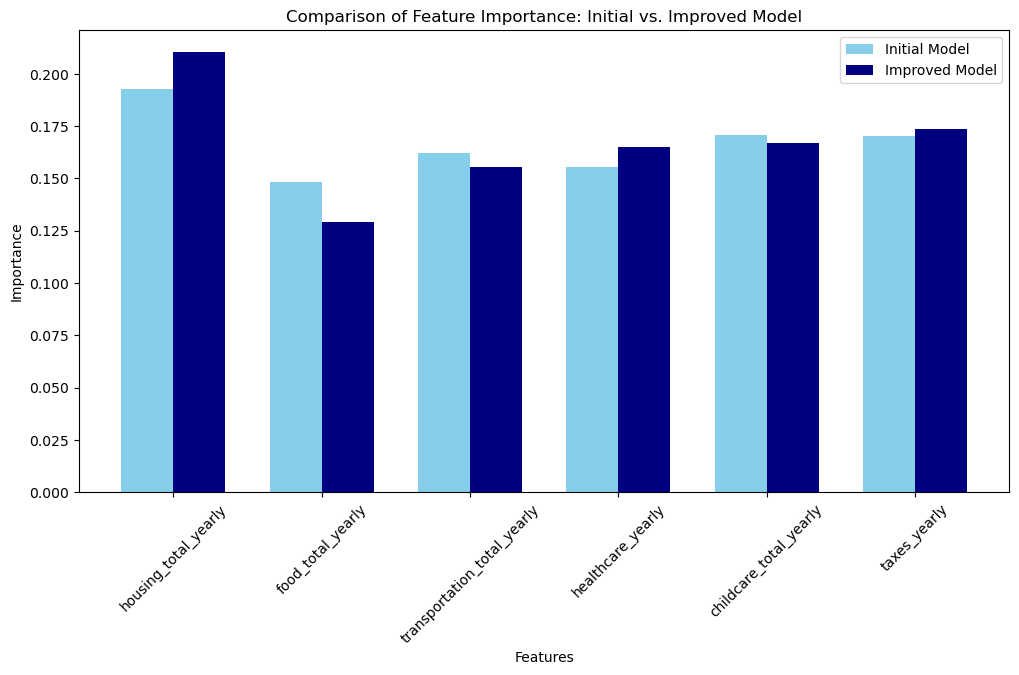

In [29]:
# Train the initial model (before optimization)
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
initial_model.fit(X_train, y_train)
initial_importances = initial_model.feature_importances_

# Train the improved model (after optimization)
improved_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
improved_model.fit(X_train, y_train)
improved_importances = improved_model.feature_importances_

# Prepare data for the grouped bar chart
features_list = features.columns
x = np.arange(len(features_list))  # Feature indices
width = 0.35  # Width of the bars

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, initial_importances, width, label='Initial Model', color='skyblue')
bars2 = ax.bar(x + width/2, improved_importances, width, label='Improved Model', color='navy')

# Add labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Comparison of Feature Importance: Initial vs. Improved Model')
ax.set_xticks(x)
ax.set_xticklabels(features_list, rotation=45)
ax.legend()

plt.show()

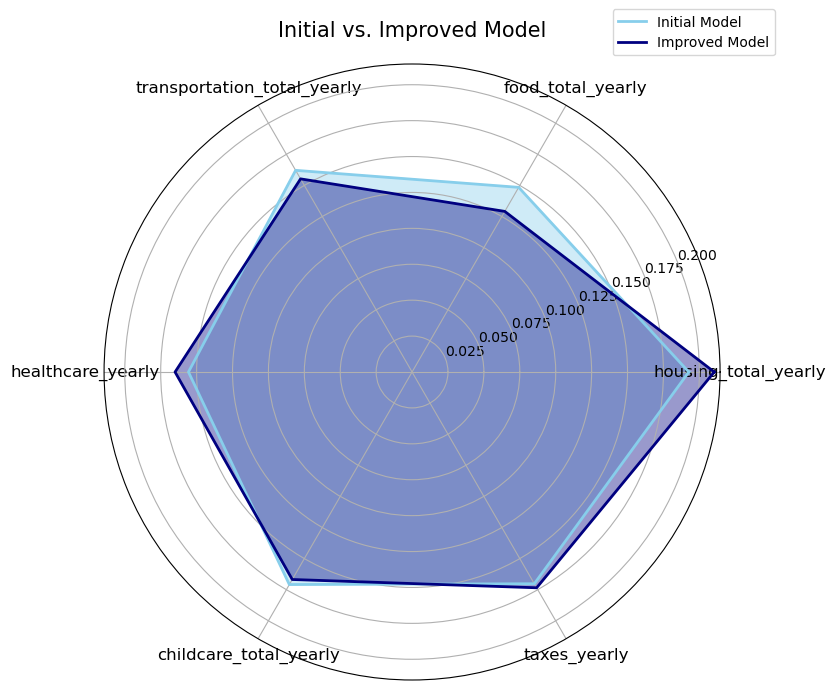

In [30]:
# Combine feature importances from both models
initial_importances = initial_model.feature_importances_
improved_importances = improved_model.feature_importances_

# Prepare data for the radar chart
categories = features.columns
num_vars = len(categories)

# Create angle values for each feature in the radar chart
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Extend the importance lists to complete the radar chart loop
initial_importances = np.append(initial_importances, initial_importances[0])
improved_importances = np.append(improved_importances, improved_importances[0])

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data for both models
ax.plot(angles, initial_importances, linewidth=2, linestyle='solid', label='Initial Model', color='skyblue')
ax.fill(angles, initial_importances, alpha=0.4, color='skyblue')

ax.plot(angles, improved_importances, linewidth=2, linestyle='solid', label='Improved Model', color='navy')
ax.fill(angles, improved_importances, alpha=0.4, color='navy')

# Add feature labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_title('Initial vs. Improved Model', size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()